# Paths and imports

In [1]:
# Cell 0. Case selection and paths (case-first layout)
from pathlib import Path

ROOT = Path("..").resolve()

CASE_ID  = "crab_112"
CASE_DIR = ROOT / "data" / "cases" / CASE_ID
assert CASE_DIR.exists(), f"Missing CASE_DIR: {CASE_DIR}"

CASE_JSONL      = CASE_DIR / f"{CASE_ID}.jsonl"
OCCLUDED_PNG    = CASE_DIR / "occluded.png"
SHAPES_XY_NPZ   = CASE_DIR / "generated" / "shapes_xy.npz"
COMPLETIONS_DIR = CASE_DIR / "generated" / "completions"
GT_PNG = CASE_DIR / "gt.png"

for p in [CASE_JSONL, OCCLUDED_PNG, SHAPES_XY_NPZ, COMPLETIONS_DIR]:
    assert p.exists(), f"Missing: {p}"

OUT_DIR = CASE_DIR / "results" / "planB"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("CASE_DIR:", CASE_DIR)
print("OUT_DIR :", OUT_DIR)


CASE_DIR: /Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112
OUT_DIR : /Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/results/planB


In [2]:
# Cell 1. Load class names (JSONL: one JSON object per line)
import json

CLASS_NAMES_JSONL = ROOT / "data" / "class_names.jsonl"
with CLASS_NAMES_JSONL.open("r", encoding="utf-8") as f:
    classes = [json.loads(line)["class_name"] for line in f if line.strip()]

print("Loaded class list:", len(classes))


Loaded class list: 54


In [3]:
# Cell 2. Load shapes_xy.npz and resolve completion PNG paths
import numpy as np

z = np.load(SHAPES_XY_NPZ, allow_pickle=True)
out_files_raw = z["out_files"].tolist()
polygons_xy   = z["polygons"]
matlab_1_indexed = bool(z["matlab_1_indexed"]) if "matlab_1_indexed" in z else False

def resolve_png_path(p: str) -> Path:
    pth = Path(p)
    if pth.exists():
        return pth
    return (COMPLETIONS_DIR / pth.name)

png_paths = [resolve_png_path(p) for p in out_files_raw]
N = len(png_paths)

missing = sum(1 for p in png_paths if not p.exists())
print("N completions:", N)
print("Missing PNGs :", missing)


N completions: 10000
Missing PNGs : 0


# Inference from ONNX

In [4]:
# Cell 3. ONNX session + preprocessing
import onnxruntime as ort
import numpy as np
from PIL import Image

ONNX_PATH = ROOT / "data" / "models" / "resnet50_geirhos_tl_with_feats.onnx"

sess = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

IMG_SIZE = 224

def preprocess_imagenet(img: Image.Image, size: int = 224) -> np.ndarray:
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((size, size), resample=Image.BILINEAR)
    x = (np.asarray(img).astype(np.float32) / 255.0)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    x = (x - mean[None, None, :]) / std[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]
    return x.astype(np.float32)

def infer_logits(path: Path) -> np.ndarray:
    img = Image.open(path)
    x = preprocess_imagenet(img, IMG_SIZE)
    y = sess.run([output_name], {input_name: x})[0]
    return np.asarray(y).reshape(-1)

def softmax(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)


In [5]:
# Cell 4. Baseline target selection from occluded image (Plan B uses same target logic as Plan A)
occ_logits = infer_logits(OCCLUDED_PNG)
occ_prob = softmax(occ_logits)

target_idx = int(np.argmax(occ_logits))
TARGET_CLASS = classes[target_idx]

occ_tlog = float(occ_logits[target_idx])
occ_tpr  = float(occ_prob[target_idx])

print("Target from occluded baseline:")
print("  TARGET_CLASS:", TARGET_CLASS)
print("  target_idx  :", target_idx)
print("  baseline logit:", occ_tlog)
print("  baseline prob :", occ_tpr)

top10 = np.argsort(-occ_logits)[:10]
print("\nTop-10 baseline classes:")
for r, j in enumerate(top10, start=1):
    print(f"  {r:02d}. {classes[int(j)]:>12s}  logit={float(occ_logits[j]): .4f}  prob={float(occ_prob[j]): .4f}")


Target from occluded baseline:
  TARGET_CLASS: crab
  target_idx  : 15
  baseline logit: 9.16638469696045
  baseline prob : 0.4102046489715576

Top-10 baseline classes:
  01.         crab  logit= 9.1664  prob= 0.4102
  02.       spider  logit= 8.7624  prob= 0.2739
  03.      lobster  logit= 7.7655  prob= 0.1011
  04.       beetle  logit= 7.6910  prob= 0.0938
  05.         tick  logit= 7.4420  prob= 0.0731
  06.          ant  logit= 6.4759  prob= 0.0278
  07.     mosquito  logit= 5.2807  prob= 0.0084
  08.          fly  logit= 4.8220  prob= 0.0053
  09.          bug  logit= 4.6140  prob= 0.0043
  10.       shrimp  logit= 3.1468  prob= 0.0010


# Scoring of completions

In [ ]:
# Cell 5. Score all completions (logit, prob, margin, delta vs baseline)
from tqdm.auto import tqdm

tlog = np.full(N, np.nan, dtype=np.float64)
tpr  = np.full(N, np.nan, dtype=np.float64)
tmar = np.full(N, np.nan, dtype=np.float64)
tdel = np.full(N, np.nan, dtype=np.float64)

for i in tqdm(range(N)):
    p = png_paths[i]
    if not p.exists():
        continue
    logits = infer_logits(p)
    prob = softmax(logits)

    tl = float(logits[target_idx])
    tlog[i] = tl
    tpr[i]  = float(prob[target_idx])
    tdel[i] = float(tl - occ_tlog)

    # margin = target logit - best other logit
    other_max = float(np.max(np.delete(logits, target_idx)))
    tmar[i] = float(tl - other_max)

print("Scored completions. Finite:", int(np.isfinite(tlog).sum()), "/", N)


  0%|          | 0/10000 [00:00<?, ?it/s]

Scored completions. Finite: 10000 / 10000


# Choosing Subset based on scores

In [8]:
# Cell 6 (REVISED). Eligible set E = all valid samples (no baseline-improvement filter)
import numpy as np

N_total = len(png_paths)

# Start with "has a score" criterion
E = np.isfinite(tlog)

# Optional: also require valid polygon if you have that flag
# (only do this if valid_poly exists and is aligned with global indices)
if "valid_poly" in globals():
    valid_poly_arr = np.asarray(valid_poly, dtype=bool)
    if valid_poly_arr.shape[0] == N_total:
        E = E & valid_poly_arr
    else:
        print("Warning: valid_poly exists but length != N_total. Skipping valid_poly filter.")

E_idx = np.where(E)[0].astype(int)

print("Eligible set size (all finite logits):", len(E_idx), "/", N_total)


Eligible set size (all finite logits): 10000 / 10000


# Choosing subset penultimate

In [10]:
# Cell. Set ONNX output names (penultimate + logits) and sanity-check
import numpy as np
import onnxruntime as ort
from pathlib import Path
from PIL import Image

SESSION = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])

IN_NAME = SESSION.get_inputs()[0].name
PENULT_OUT_NAME = "features"
LOGITS_OUT_NAME = "output"

IM_SIZE = 224
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_png(p: str | Path) -> np.ndarray:
    img = Image.open(p).convert("RGB").resize((IM_SIZE, IM_SIZE), resample=Image.BILINEAR)
    x = np.asarray(img, dtype=np.float32) / 255.0
    x = (x - MEAN[None, None, :]) / STD[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]
    return x.astype(np.float32, copy=False)

def infer_penult_logits(p: str | Path):
    x = preprocess_png(p)
    pen, log = SESSION.run([PENULT_OUT_NAME, LOGITS_OUT_NAME], {IN_NAME: x})
    return np.asarray(pen), np.asarray(log)

# sanity check on two different completions (or baseline + completion)
p1 = png_paths[int(E_idx[0])]
p2 = png_paths[int(E_idx[min(1, len(E_idx)-1)])]

pen1, log1 = infer_penult_logits(p1)
pen2, log2 = infer_penult_logits(p2)

print("penult shapes:", pen1.shape, pen2.shape)
print("logit shapes :", log1.shape, log2.shape)
print("penult L2 distance (same preprocessing):", float(np.linalg.norm(pen1.reshape(-1) - pen2.reshape(-1))))
print("logit  L2 distance:", float(np.linalg.norm(log1.reshape(-1) - log2.reshape(-1))))


penult shapes: (1, 2048) (1, 2048)
logit shapes : (1, 54) (1, 54)
penult L2 distance (same preprocessing): 2.3801538944244385
logit  L2 distance: 1.21405029296875


In [13]:
# Cell 7 (REVISED). Build penultimate-layer embeddings with ONNXRuntime
# Replaces "logits as embeddings" with features from the penultimate layer.
#
# You MUST set PENULT_OUT_NAME to the correct ONNX output name for the penultimate tensor.
# Run the "inspect outputs" cell below once to find it.

import numpy as np
import onnxruntime as ort
from pathlib import Path
from PIL import Image

# --- paths / model ---
SESSION = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])

# Find input name
IN_NAME = SESSION.get_inputs()[0].name

# Set this after inspecting outputs (next cell).
PENULT_OUT_NAME = "features"  # e.g. "avgpool" or "features" or similar
LOGITS_OUT_NAME = "output"  # optional, if model has logits output too

# --- preprocessing: adjust if your pipeline differs ---
IM_SIZE = 224
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_png(p: str | Path) -> np.ndarray:
    img = Image.open(p).convert("RGB").resize((IM_SIZE, IM_SIZE), resample=Image.BILINEAR)
    x = np.asarray(img, dtype=np.float32) / 255.0
    x = (x - MEAN[None, None, :]) / STD[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]  # (1,3,224,224)
    return x.astype(np.float32, copy=False)

def infer_penult_and_logits(p: str | Path):
    x = preprocess_png(p)
    outs = [PENULT_OUT_NAME] + ([LOGITS_OUT_NAME] if LOGITS_OUT_NAME else [])
    y = SESSION.run(outs, {IN_NAME: x})
    pen = y[0]
    log = y[1] if LOGITS_OUT_NAME else None
    return pen, log

# --- build embedding matrix X from penultimate layer ---
if PENULT_OUT_NAME is None:
    raise RuntimeError("Set PENULT_OUT_NAME first. Run the output-inspection cell to find the right name.")

# We'll infer one item to get feature dimension
pen0, _ = infer_penult_and_logits(png_paths[int(E_idx[0])])
pen0 = np.asarray(pen0)
X_dim = int(np.prod(pen0.shape[1:]))  # flatten all but batch
X = np.zeros((len(E_idx), X_dim), dtype=np.float32)

for j, i in enumerate(E_idx):
    pen, _ = infer_penult_and_logits(png_paths[int(i)])
    pen = np.asarray(pen, dtype=np.float32)
    X[j] = pen.reshape(-1).astype(np.float32, copy=False)

# L2 normalize
norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
Xn = X / norm

print("Penultimate embedding matrix Xn:", Xn.shape)


Penultimate embedding matrix Xn: (10000, 2048)


In [14]:
# Cell 7b (OPTIONAL). Cache embeddings + aligned indices so you never recompute ONNX
import numpy as np
from pathlib import Path

CACHE_DIR = Path(CASE_DIR) / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

emb_path = CACHE_DIR / "penult_Xn.npy"
idx_path = CACHE_DIR / "E_idx.npy"

np.save(emb_path, Xn.astype(np.float32, copy=False))
np.save(idx_path, np.asarray(E_idx, dtype=np.int32))

print("Saved:", emb_path)
print("Saved:", idx_path)


Saved: /Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/cache/penult_Xn.npy
Saved: /Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/cache/E_idx.npy


In [15]:
# Cell 8. PCA denoise / compress (run this right after Xn exists)
import numpy as np
from sklearn.decomposition import PCA

PCA_D = 30  # 15-50 typical
pca = PCA(n_components=int(PCA_D), random_state=0)
Z = pca.fit_transform(Xn)

evr = pca.explained_variance_ratio_
print("Z:", Z.shape)
print("Explained variance first 10:", np.round(evr[:10], 4))
print("Cumulative EV:", float(evr.sum()))


Z: (10000, 30)
Explained variance first 10: [0.2479 0.191  0.114  0.0637 0.05   0.0351 0.0309 0.0255 0.0214 0.0199]
Cumulative EV: 0.9326820969581604


# Clustering

In [16]:
# Cell 9 (REVISED). Cluster into hypotheses using BayesianGaussianMixture (more stable defaults)
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

K_MAX = 80
bgmm = BayesianGaussianMixture(
    n_components=int(K_MAX),
    covariance_type="diag",  # <<< change: more stable + faster
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-2,
    max_iter=2000,
    random_state=0,
    init_params="kmeans",
    reg_covar=1e-6,          # <<< change: avoid singular covariances
)
bgmm.fit(Z)

resp = bgmm.predict_proba(Z)  # (|E|, K_MAX)
mix_w = np.asarray(bgmm.weights_, dtype=np.float64)

# <<< change: use a smaller threshold to define "active"
ACTIVE_THR = 1e-4
active = np.where(mix_w > ACTIVE_THR)[0]

print("Active components:", len(active), "/", K_MAX, " (thr=", ACTIVE_THR, ")")
print("Top 10 mixture weights:", np.round(np.sort(mix_w)[::-1][:10], 6))


Active components: 26 / 80  (thr= 0.0001 )
Top 10 mixture weights: [0.214343 0.15961  0.14284  0.083437 0.066168 0.047507 0.047282 0.035711
 0.033973 0.02854 ]


# Debiasing

In [ ]:
# Cell 9. Build occluder mask (pixel space) ONCE. from case.jsonl (recommended)
import json
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw

case_row = json.loads(CASE_JSONL.read_text(encoding="utf-8").splitlines()[-1])

occ_u = np.asarray(case_row["occluder_rect_xy"], dtype=np.float64)
bounds = case_row["shape_bounds"]
min_u = np.asarray(bounds["min"], dtype=np.float64)
max_u = np.asarray(bounds["max"], dtype=np.float64)

W_img, H_img = Image.open(OCCLUDED_PNG).size

def unit_to_pixel_affine(u_xy: np.ndarray) -> np.ndarray:
    u = np.asarray(u_xy, dtype=np.float64).reshape(-1, 2)
    x = (u[:, 0] - min_u[0]) / max(1e-12, (max_u[0] - min_u[0])) * (W_img - 1)
    y = (u[:, 1] - min_u[1]) / max(1e-12, (max_u[1] - min_u[1])) * (H_img - 1)
    return np.column_stack([x, y])

occluder_px = unit_to_pixel_affine(occ_u)

occ_mask_img = Image.new("L", (W_img, H_img), 0)
draw = ImageDraw.Draw(occ_mask_img)
draw.polygon([(float(x), float(y)) for x, y in occluder_px], outline=1, fill=1)
occluder_mask = (np.asarray(occ_mask_img, dtype=np.uint8) > 0)

occ_area_px = float(occluder_mask.sum() + 1e-12)

print("Occluder mask px:", int(occluder_mask.sum()))


In [19]:
# Cell 10. Recompute curvature aligned to E_idx (curv) for debiasing
import numpy as np
from shapely.geometry import Point, Polygon

occ_poly = Polygon(np.asarray(occluder_px, dtype=np.float64).tolist())

def turning_curvature(polyline_xy: np.ndarray, eps: float = 1e-12) -> float:
    x = np.asarray(polyline_xy, dtype=np.float64)
    if x.shape[0] < 3:
        return np.nan
    v1 = x[1:-1] - x[:-2]
    v2 = x[2:]   - x[1:-1]
    n1 = np.linalg.norm(v1, axis=1) + eps
    n2 = np.linalg.norm(v2, axis=1) + eps
    v1u = v1 / n1[:, None]
    v2u = v2 / n2[:, None]
    dot = np.clip(np.sum(v1u * v2u, axis=1), -1.0, 1.0)
    cross = v1u[:, 0] * v2u[:, 1] - v1u[:, 1] * v2u[:, 0]
    ang = np.arctan2(cross, dot)
    total_turn = np.sum(np.abs(ang))
    seg = x[1:] - x[:-1]
    arc_len = float(np.sum(np.linalg.norm(seg, axis=1)))
    return float(total_turn / (arc_len + eps))

def points_inside_occluder(xy: np.ndarray, poly: Polygon) -> np.ndarray:
    if xy.size == 0:
        return xy.reshape(0, 2)
    inside = []
    for p in xy:
        if poly.contains(Point(float(p[0]), float(p[1]))):
            inside.append(p)
    return np.asarray(inside, dtype=np.float64) if inside else np.zeros((0, 2), dtype=np.float64)

curv = np.full((len(E_idx),), np.nan, dtype=np.float64)

for j, i in enumerate(E_idx):
    pts = np.asarray(polygons_xy[int(i)], dtype=np.float64).reshape(-1, 2)
    if "matlab_1_indexed" in globals() and matlab_1_indexed:
        pts = pts - 1.0
    pts_in = points_inside_occluder(pts, occ_poly)
    curv[j] = turning_curvature(pts_in) if pts_in.shape[0] >= 3 else turning_curvature(pts)

print("curv:", curv.shape, "finite:", int(np.isfinite(curv).sum()))


curv: (10000,) finite: 10000


In [20]:
# Cell 10. Binary masks from PNGs. compute fill_in_occ and fill_added_in_occ
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

def png_to_shape_mask(p: Path) -> np.ndarray:
    # black shape on white background
    arr = np.asarray(Image.open(p).convert("L"), dtype=np.uint8)
    return arr < 128

# baseline occluded mask
baseline_mask = png_to_shape_mask(OCCLUDED_PNG)

fill_in_occ = np.full((len(E_idx),), np.nan, dtype=np.float64)
fill_added_in_occ = np.full((len(E_idx),), np.nan, dtype=np.float64)

for j, i in enumerate(tqdm(E_idx)):
    p = Path(png_paths[int(i)])
    if not p.exists():
        continue

    m = png_to_shape_mask(p)

    # total shape fraction inside occluder
    fill_in_occ[j] = float(m[occluder_mask].mean())

    # added shape fraction inside occluder vs baseline
    added = m & (~baseline_mask)
    fill_added_in_occ[j] = float(added[occluder_mask].mean())

print("fill_in_occ stats min/mean/max =",
      float(np.nanmin(fill_in_occ)), float(np.nanmean(fill_in_occ)), float(np.nanmax(fill_in_occ)))
print("fill_added_in_occ stats min/mean/max =",
      float(np.nanmin(fill_added_in_occ)), float(np.nanmean(fill_added_in_occ)), float(np.nanmax(fill_added_in_occ)))

print("unique fill_in_occ (1e-4):", int(np.unique(np.round(fill_in_occ[np.isfinite(fill_in_occ)], 4)).size))
print("unique fill_added_in_occ (1e-4):", int(np.unique(np.round(fill_added_in_occ[np.isfinite(fill_added_in_occ)], 4)).size))


  0%|          | 0/10000 [00:00<?, ?it/s]

fill_in_occ stats min/mean/max = 0.0 0.0 0.0
fill_added_in_occ stats min/mean/max = 0.0 0.0 0.0
unique fill_in_occ (1e-4): 1
unique fill_added_in_occ (1e-4): 1


In [21]:
# Cell 12 (REVISED). Stable debias weights: curvature × fill_in_occ (quantile bins + cap)
import numpy as np
import pandas as pd

size_metric = fill_in_occ  # <-- use total shape-vs-background inside occluder

curv_safe = np.asarray(curv, dtype=np.float64).copy()
curv_safe[~np.isfinite(curv_safe)] = float(np.nanmedian(curv_safe))

ok = np.isfinite(curv_safe) & np.isfinite(size_metric)
if int(ok.sum()) < 50:
    raise RuntimeError(f"Too few valid samples for debiasing: {int(ok.sum())}")

def invfreq_weights_quantile(x: np.ndarray, bins: int) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    # quantile bin edges to equalize counts
    qs = np.linspace(0.0, 1.0, int(bins) + 1)
    edges = np.quantile(x, qs)
    # avoid identical edges collapsing bins
    edges[0] -= 1e-12
    edges[-1] += 1e-12
    b = np.digitize(x, edges) - 1
    b = np.clip(b, 0, bins - 1)
    cnt = np.bincount(b, minlength=bins).astype(np.float64)
    p = cnt / (cnt.sum() + 1e-12)
    w = 1.0 / (p[b] + 1e-12)
    w = w / (w.mean() + 1e-12)
    return w

BINS_CURV = 20
BINS_SIZE = 20

w_curv = np.ones((len(E_idx),), dtype=np.float64)
w_size = np.ones((len(E_idx),), dtype=np.float64)

w_curv[ok] = invfreq_weights_quantile(curv_safe[ok], bins=BINS_CURV)
w_size[ok] = invfreq_weights_quantile(size_metric[ok], bins=BINS_SIZE)

w_joint = w_curv * w_size

# cap extreme weights (prevents a few samples dominating)
CAP = 10.0
w_joint[ok] = np.clip(w_joint[ok], 1.0 / CAP, CAP)

# renormalize to mean 1
w_joint[ok] = w_joint[ok] / (np.mean(w_joint[ok]) + 1e-12)

print("w_joint stats min/mean/max =", float(w_joint[ok].min()), float(w_joint[ok].mean()), float(w_joint[ok].max()))

# masses
mass_raw = resp.sum(axis=0)
mass_debias = (w_joint[:, None] * resp).sum(axis=0)

comp_df = pd.DataFrame({
    "k": np.arange(resp.shape[1], dtype=int),
    "mix_weight": mix_w,
    "mass_raw": mass_raw,
    "mass_debias": mass_debias,
})

active_df = comp_df.query("mix_weight > 1e-4").copy()
active_df = active_df.sort_values("mass_debias", ascending=False).reset_index(drop=True)

print("Active components:", active_df.shape[0], "/", resp.shape[1])
active_df.head(15)


w_joint stats min/mean/max = 0.9999999999990002 0.9999999999989999 0.9999999999990002
Active components: 26 / 80


,k,mix_weight,mass_raw,mass_debias
0,13,0.214343,2145.897174,2145.897174
1,63,0.159610,1618.831926,1618.831926
2,0,0.142840,1427.539845,1427.539845
3,18,0.083437,835.379202,835.379202
4,46,0.066168,666.052239,666.052239
5,72,0.047507,490.023373,490.023373
6,49,0.047282,476.080998,476.080998
7,23,0.035711,357.295218,357.295218
8,45,0.033973,341.406344,341.406344
9,58,0.028540,287.972828,287.972828


# Choose hypothesis by debiased mass

In [22]:
# Cell. B1 Choose strongest hypothesis (component) by debiased mass
import numpy as np

# expects: active_df with columns ["k","mass_debias","mix_weight"] sorted desc by mass_debias
k_star = int(active_df.iloc[0]["k"])
mass_star = float(active_df.iloc[0]["mass_debias"])
mixw_star = float(active_df.iloc[0]["mix_weight"])

print("Strongest hypothesis k* =", k_star)
print("  mass_debias:", mass_star)
print("  mix_weight :", mixw_star)


Strongest hypothesis k* = 13
  mass_debias: 2145.8971742484696
  mix_weight : 0.21434270565285712


In [23]:
# Cell 2 (FIXED). Align tlog to the same eligible set as resp, then pick representative for k*
import numpy as np
from pathlib import Path

# resp is computed on the PCA/BGMM subset (Z). Its rows define the "eligible set" for clustering:
nE = int(resp.shape[0])

# We need tlog to be length nE and in the same order.
# Common situations:
#  (A) you already have tlog_E for that subset
#  (B) you only have tlog_all for all 10k completions. then you must index with E_idx.
# This cell handles both robustly.

# 1) choose the correct tlog array aligned to resp rows
if "tlog_E" in globals() and len(tlog_E) == nE:
    tlog_aligned = np.asarray(tlog_E, dtype=np.float64)
elif "tlog" in globals() and len(tlog) == nE:
    tlog_aligned = np.asarray(tlog, dtype=np.float64)
elif "tlog" in globals() and "E_idx" in globals() and len(tlog) >= int(np.max(E_idx)) + 1:
    # tlog is "global" (length N_total). align using E_idx (length nE)
    tlog_aligned = np.asarray(tlog, dtype=np.float64)[np.asarray(E_idx, dtype=int)]
else:
    raise RuntimeError(
        "Cannot align tlog to resp rows.\n"
        f"resp rows nE={nE}\n"
        f"Available: tlog len={len(tlog) if 'tlog' in globals() else 'NA'}, "
        f"E_idx len={len(E_idx) if 'E_idx' in globals() else 'NA'}, "
        f"tlog_E len={len(tlog_E) if 'tlog_E' in globals() else 'NA'}\n"
        "Fix: ensure you either compute logits only for the eligible subset (tlog_E), "
        "or keep tlog for all completions and provide E_idx used to build Z/resp."
    )

# 2) responsibilities for the strongest hypothesis
rik = resp[:, int(k_star)].astype(np.float64)

finite = np.isfinite(rik) & np.isfinite(tlog_aligned)
if int(finite.sum()) == 0:
    raise RuntimeError("No finite responsibilities/logits after alignment.")

cand = np.where(finite)[0]

# Representative: maximize r_ik, tie-break by target_logit
order = np.lexsort((tlog_aligned[cand], rik[cand]))
best_j = int(cand[order[-1]])              # index in eligible/clustering set (0..nE-1)

# Map to global index for png_paths
if "E_idx" in globals() and len(E_idx) == nE:
    best_i = int(np.asarray(E_idx, dtype=int)[best_j])
else:
    # If clustering was done on all completions, best_j is already global
    best_i = best_j

best_path = Path(png_paths[best_i])

print("Representative completion for k* (aligned):")
print("  k*:", int(k_star))
print("  eligible j:", best_j, " global i:", best_i)
print("  png:", best_path.name)
print("  r_ik:", float(rik[best_j]))
print("  target_logit:", float(tlog_aligned[best_j]))
if "occ_tlog" in globals():
    print("  baseline target_logit:", float(occ_tlog))


Representative completion for k* (aligned):
  k*: 13
  eligible j: 6969  global i: 6969
  png: completion_0001_06970.png
  r_ik: 0.9997257490409741
  target_logit: 9.085405349731445
  baseline target_logit: 9.16638469696045


# Comparison

In [25]:
# Cell. Certainty metrics from logits (softmax, margin, entropy, energy)
import numpy as np

def softmax(logits: np.ndarray) -> np.ndarray:
    z = np.asarray(logits, dtype=np.float64).reshape(-1)
    z = z - np.max(z)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)

def certainty_metrics(logits: np.ndarray) -> dict:
    z = np.asarray(logits, dtype=np.float64).reshape(-1)
    p = softmax(z)
    k = int(np.argmax(z))
    z_top = float(z[k])
    z_2nd = float(np.max(np.delete(z, k))) if z.size > 1 else float("-inf")
    margin = z_top - z_2nd
    p_top = float(np.max(p))
    entropy = float(-np.sum(p * np.log(p + 1e-12)))
    energy = float(np.log(np.sum(np.exp(z - np.max(z))) + 1e-12) + np.max(z))  # logsumexp
    return {
        "pred_idx": k,
        "pred_logit": z_top,
        "margin_top2": float(margin),
        "p_top1": p_top,
        "entropy": entropy,
        "energy_logsumexp": energy,
    }


In [29]:
# Cell. Compare certainty: best completion vs ground truth (and optionally baseline occluded)
from pathlib import Path
import numpy as np

# paths you should set
BEST_PNG = "/Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/generated/completions/completion_0001_06970.png"
GT_PNG   = Path(GT_PNG)                  # set this
OCC_PNG = "/Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/occluded.png"
# optionally:
# OCC_PNG  = Path(OCCLUDED_PNG)

_, logits_best = infer_penult_logits(BEST_PNG)
_, logits_gt   = infer_penult_logits(GT_PNG)
_, logits_gt   = infer_penult_logits(OCC_PNG)

m_best = certainty_metrics(logits_best)
m_gt   = certainty_metrics(logits_gt)
m_occ = certainty_metrics(logits_gt)

def pretty(m):
    cls = classes[m["pred_idx"]] if "classes" in globals() else str(m["pred_idx"])
    return {**m, "pred_class": cls}

print("BEST:", pretty(m_best))
print("GT  :", pretty(m_gt))
print("OC  :", pretty(m_occ))

# Differences (best - gt): positive margin means best is "more certain" by that metric
delta = {
    "delta_margin": m_best["margin_top2"] - m_gt["margin_top2"],
    "delta_entropy": m_best["entropy"] - m_gt["entropy"],
    "delta_p_top1": m_best["p_top1"] - m_gt["p_top1"],
    "delta_energy": m_best["energy_logsumexp"] - m_gt["energy_logsumexp"],
}
print("Δ (best - gt):", delta)


BEST: {'pred_idx': 15, 'pred_logit': 9.085405349731445, 'margin_top2': 0.5859565734863281, 'p_top1': 0.4410471289313595, 'entropy': 1.5558941285314967, 'energy_logsumexp': 9.90400889065167, 'pred_class': 'crab'}
GT  : {'pred_idx': 15, 'pred_logit': 9.16638469696045, 'margin_top2': 0.4039487838745117, 'p_top1': 0.41020462846464606, 'entropy': 1.573165216539134, 'energy_logsumexp': 10.057483846933916, 'pred_class': 'crab'}
OC  : {'pred_idx': 15, 'pred_logit': 9.16638469696045, 'margin_top2': 0.4039487838745117, 'p_top1': 0.41020462846464606, 'entropy': 1.573165216539134, 'energy_logsumexp': 10.057483846933916, 'pred_class': 'crab'}
Δ (best - gt): {'delta_margin': 0.1820077896118164, 'delta_entropy': -0.017271088007637436, 'delta_p_top1': 0.03084250046671344, 'delta_energy': -0.1534749562822455}


In [30]:
# Cell. Bar plot of class scores with class-name labels
import numpy as np
import matplotlib.pyplot as plt

def plot_class_bars(
    logits: np.ndarray,
    classes: list[str],
    *,
    top_k: int = 10,
    use_softmax: bool = False,
    title: str = "",
):
    """
    Plot top-K class scores (logits or softmax probs) with class-name labels.
    """
    z = np.asarray(logits, dtype=np.float64).reshape(-1)

    if use_softmax:
        z = z - np.max(z)
        scores = np.exp(z) / (np.sum(np.exp(z)) + 1e-12)
        ylabel = "Softmax probability"
    else:
        scores = z
        ylabel = "Logit"

    idx_sorted = np.argsort(scores)[::-1]
    top_idx = idx_sorted[:top_k]

    labels = [classes[i] for i in top_idx]
    vals = scores[top_idx]

    colors = ["tab:red" if i == top_idx[0] else "tab:blue" for i in range(len(top_idx))]

    plt.figure(figsize=(0.9 * top_k + 2, 4))
    plt.bar(range(len(vals)), vals, color=colors)
    plt.xticks(range(len(vals)), labels, rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()


Saved metrics → /Users/I743312/Documents/monte-carlo-selection/data/cases/crab_112/results/planB/certainty_metrics.jsonl


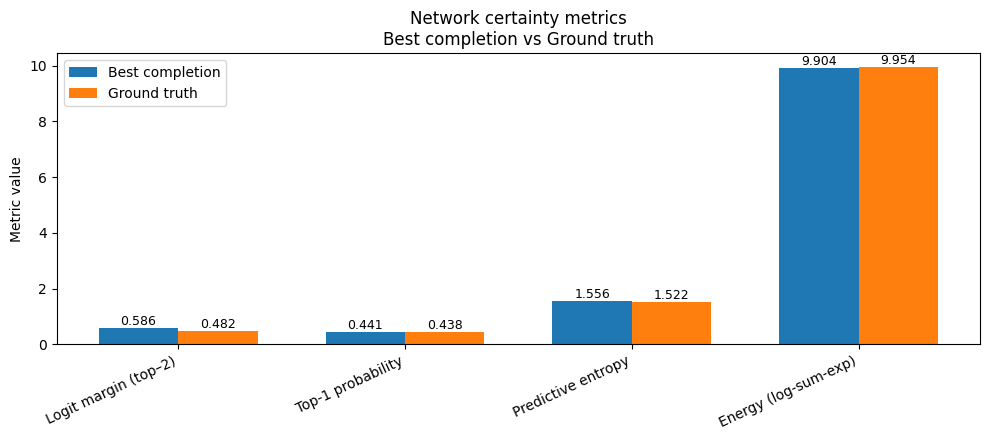

Metric interpretation:
  Logit margin (top–2): higher = more certain
  Top-1 probability: higher = more certain
  Predictive entropy: lower = more certain
  Energy (log-sum-exp): higher = more certain

Predicted classes:
  BEST: crab
  GT  : crab


In [31]:
# Cell. Visualize + save certainty metrics: Best vs GT
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Paths
# --------------------------------------------------
OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)
JSONL_PATH = OUT_DIR / "certainty_metrics.jsonl"

# --------------------------------------------------
# Compute metrics
# --------------------------------------------------
_, logits_best = infer_penult_logits(BEST_PNG)
_, logits_gt   = infer_penult_logits(GT_PNG)

m_best = certainty_metrics(logits_best)
m_gt   = certainty_metrics(logits_gt)

metrics = [
    ("margin_top2",      "Logit margin (top–2)",        "higher = more certain"),
    ("p_top1",           "Top-1 probability",           "higher = more certain"),
    ("entropy",          "Predictive entropy",          "lower = more certain"),
    ("energy_logsumexp", "Energy (log-sum-exp)",        "higher = more certain"),
]

labels     = [m[1] for m in metrics]
best_vals  = [m_best[m[0]] for m in metrics]
gt_vals    = [m_gt[m[0]]   for m in metrics]

# --------------------------------------------------
# Save to JSONL
# --------------------------------------------------
row = {
    "best_png": str(BEST_PNG),
    "gt_png":   str(GT_PNG),
    "best_pred_idx": int(m_best["pred_idx"]),
    "gt_pred_idx":   int(m_gt["pred_idx"]),
    "best_pred_class": classes[m_best["pred_idx"]],
    "gt_pred_class":   classes[m_gt["pred_idx"]],
    "metrics": {
        key: {
            "best": float(m_best[key]),
            "gt":   float(m_gt[key]),
            "direction": interp
        }
        for key, _, interp in metrics
    }
}

with JSONL_PATH.open("a", encoding="utf-8") as f:
    f.write(json.dumps(row) + "\n")

print(f"Saved metrics → {JSONL_PATH}")

# --------------------------------------------------
# Visualization
# --------------------------------------------------
x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(10, 4.5))
plt.bar(x - w/2, best_vals, width=w, label="Best completion")
plt.bar(x + w/2, gt_vals,   width=w, label="Ground truth")

for i, v in enumerate(best_vals):
    plt.text(i - w/2, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(gt_vals):
    plt.text(i + w/2, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels, rotation=25, ha="right")
plt.ylabel("Metric value")
plt.title("Network certainty metrics\nBest completion vs Ground truth")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Textual reminder
# --------------------------------------------------
print("Metric interpretation:")
for _, name, interp in metrics:
    print(f"  {name}: {interp}")

print("\nPredicted classes:")
print("  BEST:", classes[m_best["pred_idx"]])
print("  GT  :", classes[m_gt["pred_idx"]])
